# SMU 7331 Data Mining Project 3
##### Authors: Shon Mohsin, Heber Nielsen, Jose Torres, Lokesh Maganti

In [79]:
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.metrics import pairwise, silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn.mixture import GaussianMixture

## Business Understanding: 
#### Requirements: Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

In [80]:
# Data Import from Github
url = 'https://raw.githubusercontent.com/hebernielsen/DS7331_Project3/master/allUsers.lcl.csv' 
df=pd.read_csv(url)
df.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,...,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,1,0,54.263880,71.466776,-64.807709,76.895635,42.462500,-72.780545,36.621229,81.680557,...,?,?,?,?,?,?,?,?,?,?
2,1,0,56.527558,72.266609,-61.935252,39.135978,82.538530,-49.596509,79.223743,43.254091,...,?,?,?,?,?,?,?,?,?,?
3,1,0,55.849928,72.469064,-62.562788,37.988804,82.631347,-50.606259,78.451526,43.567403,...,?,?,?,?,?,?,?,?,?,?
4,1,0,55.329647,71.707275,-63.688956,36.561863,81.868749,-52.752784,86.320630,68.214645,...,?,?,?,?,?,?,?,?,?,?


Our selected dataset captures hand gestures using Vicon Motion Capture System using a glove with markers, described in detail in the Data Understanding section. The dataset is comprised of 12 users making 5 pre-defined hand gestures below:

1. Fist
2. Stop
3. Point with one finger
4. Point with two fingers
5. Grab

The business problem is to perform cluster analysis on the 5 gestures, regardless of user, to see if discernable patterns can be used to identify the 5 gestures from a combined set where the 12 users are de-identified. 

Our assumption is that the gestures should be similar regardless of the individual user making the gesture. 

## Data Understanding 1:
#### Requirements: Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

### Data Overview

Our selected dataset captures hand gestures using Vicon Motion Capture System. Ten Vicon MX T40 (4 megapixel) motion capture cameras available in the Micro-Aerial Vehicle and Sensor Networks (MAVSeN) Laboratory at Louisiana Tech University act as the source of data. The MAVSeN lab conducts research and development in small-scale vehicle design, cooperative intelligent sensing, and control algorithms for unmanned air and ground vehicles (see Figure 1). As the figure partially shows, the cameras are arranged roughly on the boundary of a rectangular area. The cameras are capable of recording at multiple framerates, with 50 Hz and 100 Hz being the options used in the majority of situations including data capture and interactive tests.

1. The Dataset is the collection,features and organization of motion capture datasets for hand posture and gesture recognition.


2. The purpose of this dataset is to provide the range of motion for each part of the hand/glove to which a marker is attached.


3. Glove constructed to serve as the source of data for all algorithms analysis and development.


4. A glove with fifteen markers attached is used as the source of data for posture and gesture recognition, both for the generation of datasets and for the practical evaluation of developed algorithms.


5. The glove used to capture data along with a sample from each class of posture projected onto the local XY plane. The classes are fist (1), stop (2),point with one finger (3), point with two fingers (4), and grab (5).


6. The data described here is already partially preprocessed in the following manner. The data was transformed and pruned in the same manner as the La-beled Marker Dataset. Any record that could not be transformed or contained fewer than three markers was removed.


7. This dataset may be used for a variety of tasks, the most obvious of which is posture recognition via classication. One may also attempt user identication.Alternatively, one may perform clustering (constrained or unconstrained) to discover marker distributions either as an attempt to predict marker identities or obtain statistical descriptions/visualizations of the postures.


8. Since the pattern is not always visible and has noisy or even incorrect ob-servations, alter should be used to smooth the measurements of the labeled markers.


9. The 11 markers not part of the rigid pattern were unlabeled; their positions were not explicitly tracked. Consequently, there is no a priori correspondence between the markers of two given records.


### Attribute Information:

Data is provided as a CSV file. A header provides the name of each attribute. An initial dummy record composed entirely of 0s should be ignored. A question mark '?' is used to indicate a missing value. A record corresponds to a single instant or frame as recorded by the camera system.

'Class' - Integer. The class ID of the given record. Ranges from 1 to 5 with 1=Fist(with thumb out), 2=Stop(hand flat), 3=Point1(point with pointer finger), 4=Point2(point with pointer and middle fingers), 5=Grab(fingers curled as if to grab). 'User' - Integer. The ID of the user that contributed the record. No meaning other than as an identifier.

Xi - Real. The x-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.

'Yi' - Real. The y-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.

'Zi' - Real. The z-coordinate of the i-th unlabeled marker position. 'i' ranges from 0 to 11.
Each record is a set. The i-th marker of a given record does not necessarily
correspond to the i-th marker of a dierent record. One may randomly permute
7
the visible (i.e. not missing) markers of a given record without changing the set
that the record represents. For the sake of convenience, all visible markers of
a given record are given a lower index than any missing marker. A class is not
guaranteed to have even a single record with all markers visible.

### Data Preprocessing

The sensor data is restructured so that there are three coordinate columns: X, Y, and Z.  This ensures consistency across the row axis for our data.

In [81]:
dropped_indices = df.query('Class==0').index
df = (df
      .drop(labels=dropped_indices, axis=0, errors='ignore')
      .replace(to_replace='?', value=np.nan))

#set data types and melt to a single coordinate column
df = (pd.concat([df.iloc[:,:2].astype(str), 
                df.iloc[:,2:].astype(np.float64)], axis=1)
      .melt(id_vars=['User', 'Class'])
      .dropna())

In [82]:
#replace column names with X or Y or Z depending on the axis, and relabel the classes

df['variable'] = (df['variable'].str
                  .replace('X.*', 'X', regex=True)
                  .replace('Y.*', 'Y', regex=True)
                  .replace('Z.*', 'Z', regex=True))
df['Class'] = df['Class'].map({'1': 'fist', '2': 'stop', 
                               '3': 'pointer', '4': 'pointer_middle', '5': 'grab'})

In [83]:
#Cleaned dataframe

df.head()

,User,Class,variable,value
0,0,fist,X,54.263880
1,0,fist,X,56.527558
2,0,fist,X,55.849928
3,0,fist,X,55.329647
4,0,fist,X,55.142401


In [84]:
#Pivot coordinates to have columns User, Class, X, Y, Z

df_adjacent_coords = pd.DataFrame({'User': df.query('variable==\'X\'').reset_index()['User'], 
                                   'Class': df.query('variable==\'X\'').reset_index()['Class'], 
                                   'X': df.query('variable==\'X\'').reset_index()['value'], 
                                   'Y': df.query('variable==\'Y\'').reset_index()['value'],
                                   'Z': df.query('variable==\'Z\'').reset_index()['value']})
df_adjacent_coords.head()

,User,Class,X,Y,Z
0,0,fist,54.263880,71.466776,-64.807709
1,0,fist,56.527558,72.266609,-61.935252
2,0,fist,55.849928,72.469064,-62.562788
3,0,fist,55.329647,71.707275,-63.688956
4,0,fist,55.142401,71.435607,-64.177303


In [68]:
# We group by `User` to see the participation percentage levels of each user 
df.groupby(['User']).agg(lambda grp: grp.size / df.shape[0] * 100)[['Class']]

,Class
User,
0,10.986705
1,5.787110
10,12.374396
11,10.492454
12,5.956161
13,10.380570
14,9.999510
2,5.555664
4,0.373710


### Data Visualization:

Our first visualization is of the Fist Gesture in 3D and separate 2D planes.  Here is the reference image of representative clusters we would expect to see for each user (XY plane) <img src="files/Fist.png"> <img src="files/Grab.png"> <img src="files/PointOneFinger.png"> <img src="files/PointTwoFingers.png"> <img src="files/Stop.png">.

As reference, we use user 1 and 2, as different users have different consistency on the clustering that is captured.

In [85]:
def data_query(data, gesture, user):
    result = (data
             .query('Class in \'{}\' and User in \'{}\''.format(gesture, user))
             .loc[:,['X','Y','Z']]
             .values)
    return result

In [70]:
import ipyvolume as ipv
ipv.clear()
X = data_query(df_adjacent_coords, 'fist', '0')
scatter_fist = ipv.scatter(X[:,0],X[:,1],X[:,2],color='blue',size=.25)
ipv.show()

In [71]:
import ipyvolume as ipv
ipv.clear()
X = data_query(df_adjacent_coords, 'fist', '1')
scatter_fist = ipv.scatter(X[:,0],X[:,1],X[:,2],color='blue',size=.25)
ipv.show()

In the above 3D plots, we visualize the data for the fist motion for users 0 and 1 to see the variability present between users performing the same gesture. To be consise, we do not visualize the rest of the gestures. 

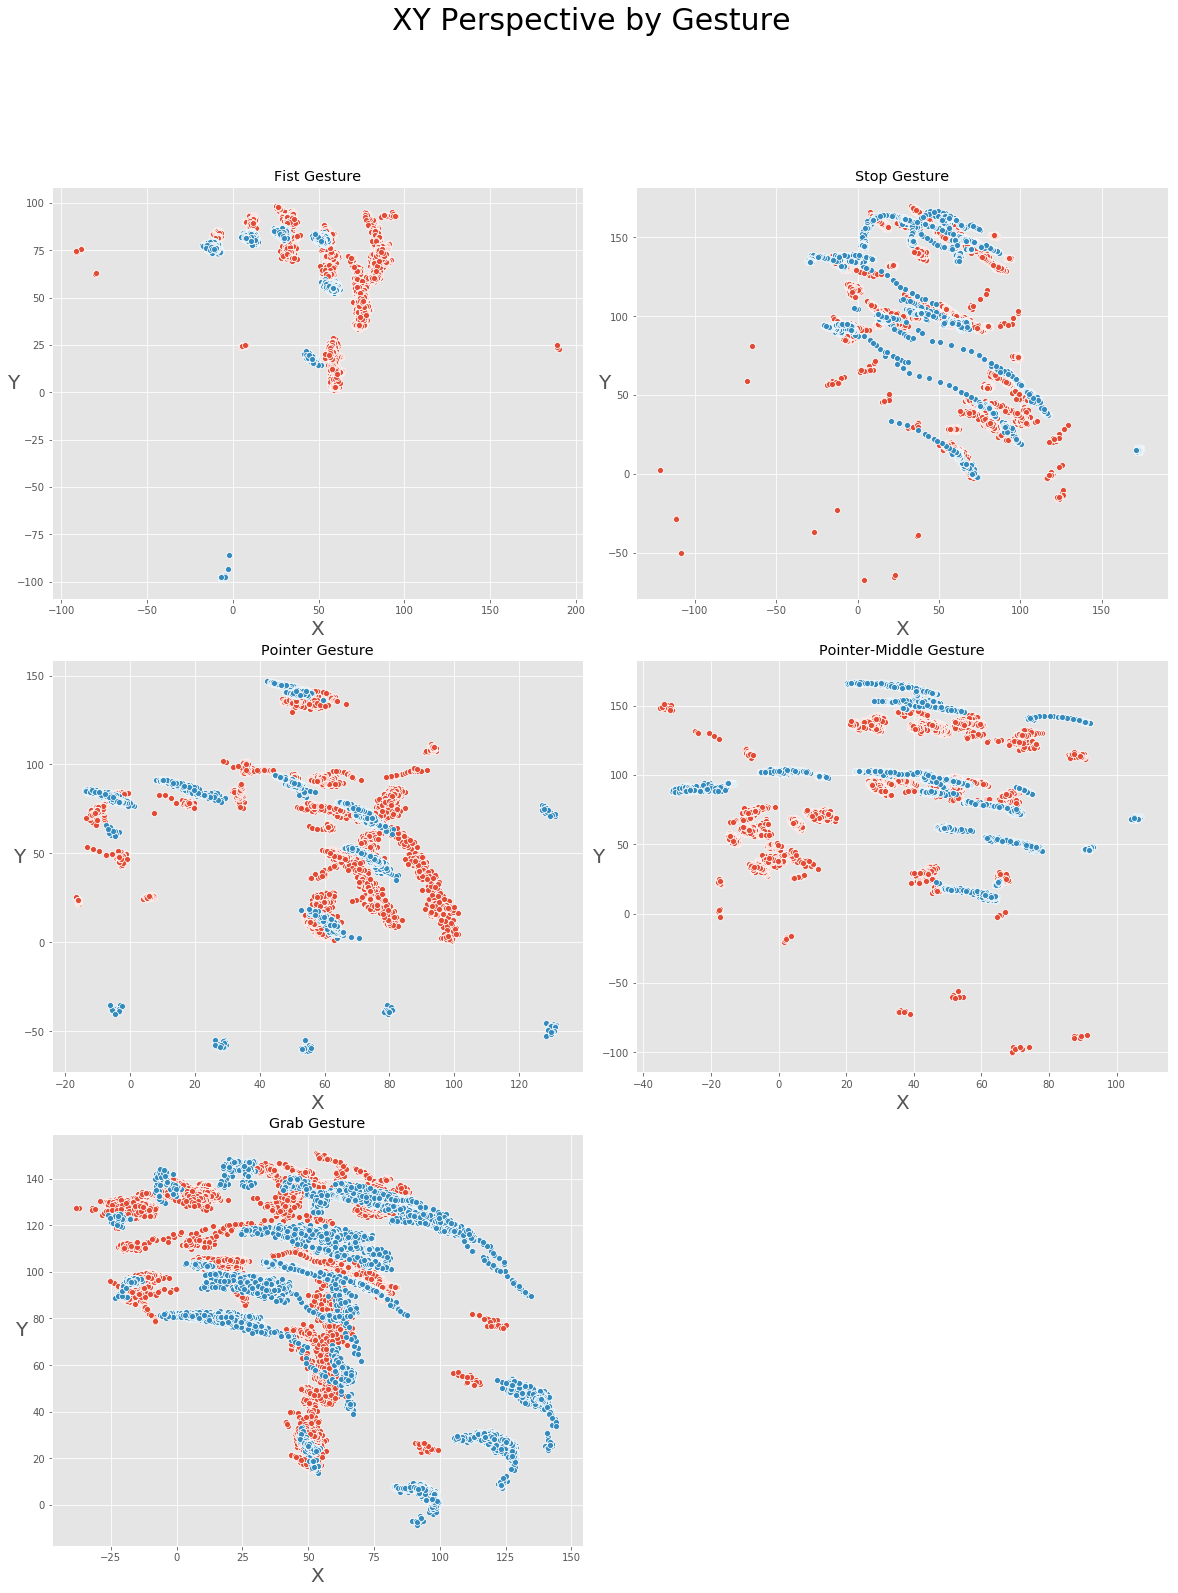

In [86]:
fig = plt.figure(figsize=(20,25))
plt.style.use('ggplot')

fig.subplots_adjust(hspace=0.15, wspace=0.1)

fist = fig.add_subplot(3,2,1)
stop = fig.add_subplot(3,2,2)
pointer = fig.add_subplot(3,2,3)
pointer_middle = fig.add_subplot(3,2,4)
grab = fig.add_subplot(3,2,5)


fig.suptitle('XY Perspective by Gesture', fontsize=30)

fist.set_title('Fist Gesture')
fist.set_xlabel('X', fontsize=20)
fist.set_ylabel('Y', fontsize=20, rotation=0)

stop.set_title('Stop Gesture')
stop.set_xlabel('X', fontsize=20)
stop.set_ylabel('Y', fontsize=20, rotation=0)

pointer.set_title('Pointer Gesture')
pointer.set_xlabel('X', fontsize=20)
pointer.set_ylabel('Y', fontsize=20, rotation=0)

pointer_middle.set_title('Pointer-Middle Gesture')
pointer_middle.set_xlabel('X', fontsize=20)
pointer_middle.set_ylabel('Y', fontsize=20, rotation=0)

grab.set_title('Grab Gesture')
grab.set_xlabel('X', fontsize=20)
grab.set_ylabel('Y', fontsize=20, rotation=0)


sns.scatterplot(x=data_query(df_adjacent_coords, 'fist', '0')[:,0], 
                y=data_query(df_adjacent_coords, 'fist', '0')[:,1], ax=fist)

sns.scatterplot(x=data_query(df_adjacent_coords, 'fist', '1')[:,0], 
                y=data_query(df_adjacent_coords, 'fist', '1')[:,1], ax=fist)

sns.scatterplot(x=data_query(df_adjacent_coords, 'stop', '0')[:,0], 
                y=data_query(df_adjacent_coords, 'stop', '0')[:,1], ax=stop)

sns.scatterplot(x=data_query(df_adjacent_coords, 'stop', '1')[:,0], 
                y=data_query(df_adjacent_coords, 'stop', '1')[:,1], ax=stop)

sns.scatterplot(x=data_query(df_adjacent_coords, 'pointer', '0')[:,0], 
                y=data_query(df_adjacent_coords, 'pointer', '0')[:,1], ax=pointer)

sns.scatterplot(x=data_query(df_adjacent_coords, 'pointer', '1')[:,0], 
                y=data_query(df_adjacent_coords, 'pointer', '1')[:,1], ax=pointer)

sns.scatterplot(x=data_query(df_adjacent_coords, 'pointer_middle', '0')[:,0], 
                y=data_query(df_adjacent_coords, 'pointer_middle', '0')[:,1], ax=pointer_middle)

sns.scatterplot(x=data_query(df_adjacent_coords, 'pointer_middle', '1')[:,0], 
                y=data_query(df_adjacent_coords, 'pointer_middle', '1')[:,1], ax=pointer_middle)

sns.scatterplot(x=data_query(df_adjacent_coords, 'grab', '0')[:,0], 
                y=data_query(df_adjacent_coords, 'grab', '0')[:,1], ax=grab)

sns.scatterplot(x=data_query(df_adjacent_coords, 'grab', '1')[:,0], 
                y=data_query(df_adjacent_coords, 'grab', '1')[:,1], ax=grab)

plt.show()

We see from plotting the data on the X-Y plane that the gestures from 2 users do not cleanly match the refernce gesture images, but there are still clear cluster positions associated with each gesture.  Some user data is much more similar to the reference image than others for a given gesture.

## Data Understanding 2:
#### Requirements: Choose and explain your evaluation metrics that you will use (i.e., accuracy, precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

We will use [silhouette scores](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) to evaluate the degree of separation between clusters. Our goal is to have the coefficients be as close to 1 as possible to have good clusters.  The silhouette score is chosen because it does not require true labels in addition to fitted cluster labels.

Many traditional metrics such as accuracy, precision, recall, and F-score do require true labels for each data record.  Therefore, none of these metrics are suitable for our clustering analysis to evaluate how well-separated clusters are from one another.

## Modeling and Evaluation 1:
#### Requirements: Train and adjust parameters

Scikit-learn offers several clustering models as part of the unsupervised learning API.  We investigated several of these, including KMeans and DBSCAN.  KMeans was chosen because there were more outlier points with DBSCAN than we thought should exist, despite trying multiple hyperparameter values for epsilon distance and minimum number of samples.  In pursuit of brevity, we do not show DBSCAN results here, instead focusing on KMeans.

### Number of clusters with silhouette analysis on KMeans clustering

We perform silhouette analysis with K-means clustering using n=(2,3,4,5,6) clusters.  This involves generating average silhouette scores for each cluster as well as computing the individual sample silhouette values for each point in each cluster (left plot in the series of plots below). Our evaluation looks at 3 values of n and the interpretation of the cluster outcomes of those values. 

In [129]:
#Fitting three KMeans models to the fist gesture

y = df_adjacent_coords['Class']
X = (df_adjacent_coords
     .query('Class==\'fist\'')
     .loc[:,['X','Y','Z']]
     .values)

cluster_labels = list()
cluster_models = list()

###Using 3 separate values of n_clusters for KMeans###
range_n_clusters = [2, 4, 6]

#fit KMeans models and generate labels for `range_n_clusters` clusters
for idx, n_clusters in enumerate(range_n_clusters):
    cluster_models.append(KMeans(n_clusters=n_clusters, random_state=10))
    cluster_labels.append(cluster_models[idx].fit_predict(X))

In [140]:
#Fitting three KMeans models to the stop gesture

y = df_adjacent_coords['Class']
X = (df_adjacent_coords
     .query('Class==\'stop\'')
     .loc[:,['X','Y','Z']]
     .values)

cluster_labels = list()
cluster_models = list()

range_n_clusters = [2,4,6]

#fit KMeans models and generate labels for `range_n_clusters` clusters
for idx, n_clusters in enumerate(range_n_clusters):
    cluster_models.append(KMeans(n_clusters=n_clusters, random_state=10))
    cluster_labels.append(cluster_models[idx].fit_predict(X))

In [143]:
#Fitting three KMeans models to the pointer gesture

y = df_adjacent_coords['Class']
X = (df_adjacent_coords
     .query('Class==\'pointer\'')
     .loc[:,['X','Y','Z']]
     .values)

cluster_labels = list()
cluster_models = list()

range_n_clusters = [2,4,6]

#fit KMeans models and generate labels for `range_n_clusters` clusters
for idx, n_clusters in enumerate(range_n_clusters):
    cluster_models.append(KMeans(n_clusters=n_clusters, random_state=10))
    cluster_labels.append(cluster_models[idx].fit_predict(X))

In [146]:
#Fitting three KMeans models to the pointer and middle finger gesture

y = df_adjacent_coords['Class']
X = (df_adjacent_coords
     .query('Class==\'pointer_middle\'')
     .loc[:,['X','Y','Z']]
     .values)

cluster_labels = list()
cluster_models = list()

range_n_clusters = [2,4,6]

#fit KMeans models and generate labels for `range_n_clusters` clusters
for idx, n_clusters in enumerate(range_n_clusters):
    cluster_models.append(KMeans(n_clusters=n_clusters, random_state=10))
    cluster_labels.append(cluster_models[idx].fit_predict(X))

In [149]:
#Fitting three KMeans models to the grab gesture

y = df_adjacent_coords['Class']
X = (df_adjacent_coords
     .query('Class==\'grab\'')
     .loc[:,['X','Y','Z']]
     .values)

cluster_labels = list()
cluster_models = list()

range_n_clusters = [2,4,6]

#fit KMeans models and generate labels for `range_n_clusters` clusters
for idx, n_clusters in enumerate(range_n_clusters):
    cluster_models.append(KMeans(n_clusters=n_clusters, random_state=10))
    cluster_labels.append(cluster_models[idx].fit_predict(X))

## Modeling and Evaluation 2:
#### Requirements: Evaluate and Compare

We evaluate 2,4, and 6 cluster sizes to see our silhouette score for different gestures with all user data included.

All silhouette scores are less than .51.  We interpret this is due to poor intra-cluster separation as a result of the variability in the data for each user.  As seen above in the data visualization section, some user data is very similar to the reference gesture image.  Other user data is very different in shape, with patterns which appear as lengthy oval shapes.  

For each gesture, the highest silouhette score is for n_clusters=2. 

In [130]:
#computer silhouette scors
silhouette_avg = list()
sample_silhouette_values = list()

for idx, n_clusters in enumerate(range_n_clusters):

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg.append(silhouette_score(X, cluster_labels[idx]))
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg[idx])

    # Compute the silhouette scores for each sample
    sample_silhouette_values.append(silhouette_samples(X, cluster_labels[idx]))

For n_clusters = 2 The average silhouette_score is : 0.42789734017111325
For n_clusters = 4 The average silhouette_score is : 0.41151744927742795
For n_clusters = 6 The average silhouette_score is : 0.3962371765911298


In [141]:
#computer silhouette scors
silhouette_avg = list()
sample_silhouette_values = list()

for idx, n_clusters in enumerate(range_n_clusters):

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg.append(silhouette_score(X, cluster_labels[idx]))
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg[idx])

    # Compute the silhouette scores for each sample
    sample_silhouette_values.append(silhouette_samples(X, cluster_labels[idx]))

For n_clusters = 2 The average silhouette_score is : 0.5112541161234943
For n_clusters = 4 The average silhouette_score is : 0.3951500882985557
For n_clusters = 6 The average silhouette_score is : 0.36594703080699104


In [144]:
#computer silhouette scors
silhouette_avg = list()
sample_silhouette_values = list()

for idx, n_clusters in enumerate(range_n_clusters):

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg.append(silhouette_score(X, cluster_labels[idx]))
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg[idx])

    # Compute the silhouette scores for each sample
    sample_silhouette_values.append(silhouette_samples(X, cluster_labels[idx]))

For n_clusters = 2 The average silhouette_score is : 0.4992117689674634
For n_clusters = 4 The average silhouette_score is : 0.363247279038618
For n_clusters = 6 The average silhouette_score is : 0.38609440385202887


In [147]:
#computer silhouette scors
silhouette_avg = list()
sample_silhouette_values = list()

for idx, n_clusters in enumerate(range_n_clusters):

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg.append(silhouette_score(X, cluster_labels[idx]))
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg[idx])

    # Compute the silhouette scores for each sample
    sample_silhouette_values.append(silhouette_samples(X, cluster_labels[idx]))

For n_clusters = 2 The average silhouette_score is : 0.5001175109245781
For n_clusters = 4 The average silhouette_score is : 0.4201751396433583
For n_clusters = 6 The average silhouette_score is : 0.36390456557790446


In [150]:
#computer silhouette scors
silhouette_avg = list()
sample_silhouette_values = list()

for idx, n_clusters in enumerate(range_n_clusters):

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg.append(silhouette_score(X, cluster_labels[idx]))
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg[idx])

    # Compute the silhouette scores for each sample
    sample_silhouette_values.append(silhouette_samples(X, cluster_labels[idx]))

For n_clusters = 2 The average silhouette_score is : 0.39862787809943134
For n_clusters = 4 The average silhouette_score is : 0.34933151037612
For n_clusters = 6 The average silhouette_score is : 0.3412708584033564


## Modeling and Evaluation 3:
#### Requirements: Visualize Results

In the set of figures below, we show two subplots for each gesture.  

The left subplot shows the silhouette scores for every data point recorded for that gesture.  This is seen as a color-coded horizontal line from the y-axis out to the value of the silhouette score.  A dashed vertical line marks the average silhouette score for all data points in all clusters.

The right subplot shows every point for that gesture, color-coded based on the cluster that contains it.  The particular orientation of this data is the X-Y sensor plane, which matches the orientation of the visuals introduced in the visualization section earlier in the report.

In [131]:
#create cluster visual
def silhouette_plots(range_n_clusters, sample_silhouette_values, cluster_labels, X):
    for idx, n_clusters in enumerate(range_n_clusters):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[idx][cluster_labels[idx] == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg[idx], color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels[idx].astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = cluster_models[idx].cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
return plt

<module 'matplotlib.pyplot' from '/home/jat055000_gmail_com/anaconda3/envs/py37/lib/python3.6/site-packages/matplotlib/pyplot.py'>

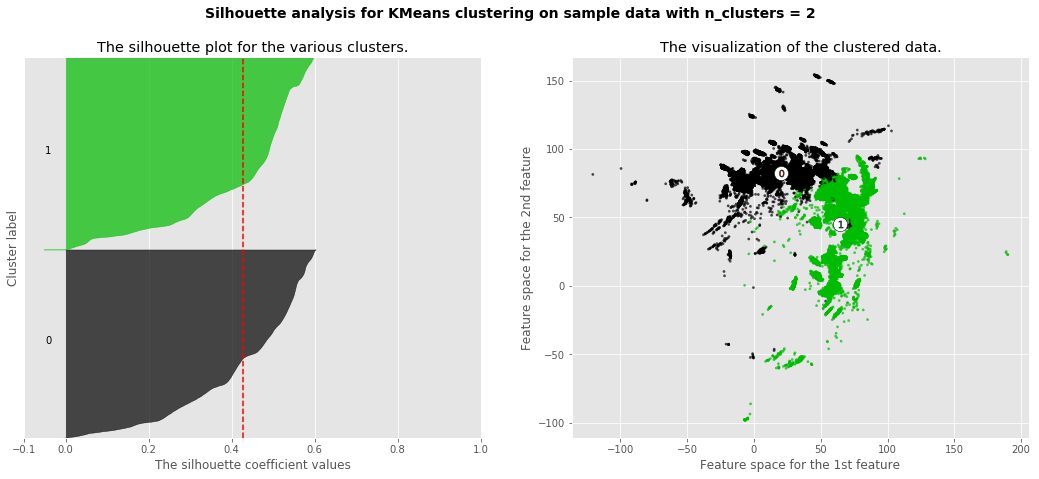

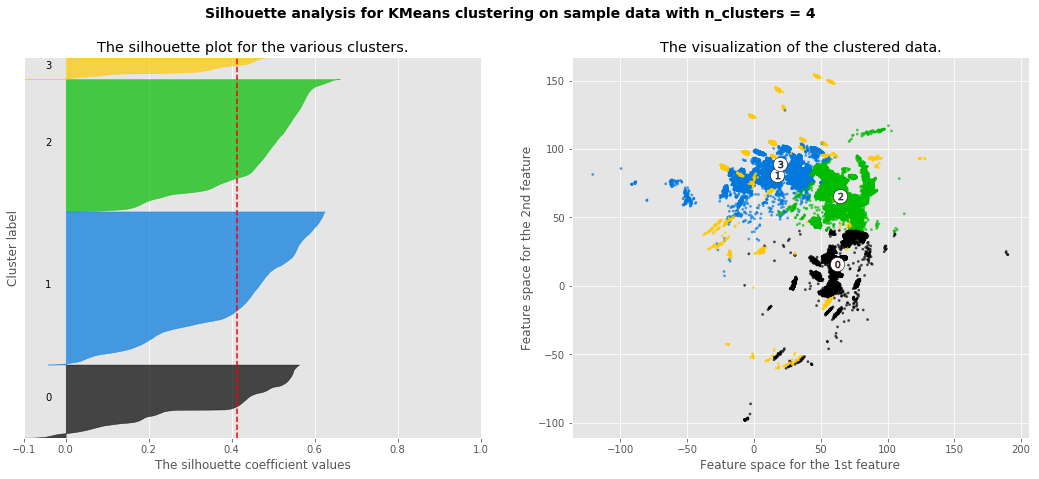

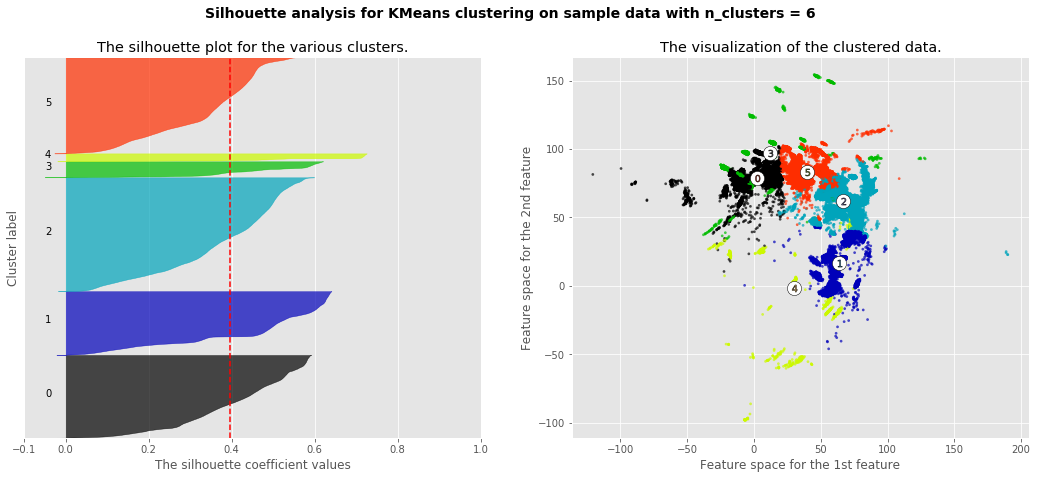

In [132]:
silhouette_plots(range_n_clusters, sample_silhouette_values, cluster_labels, X)

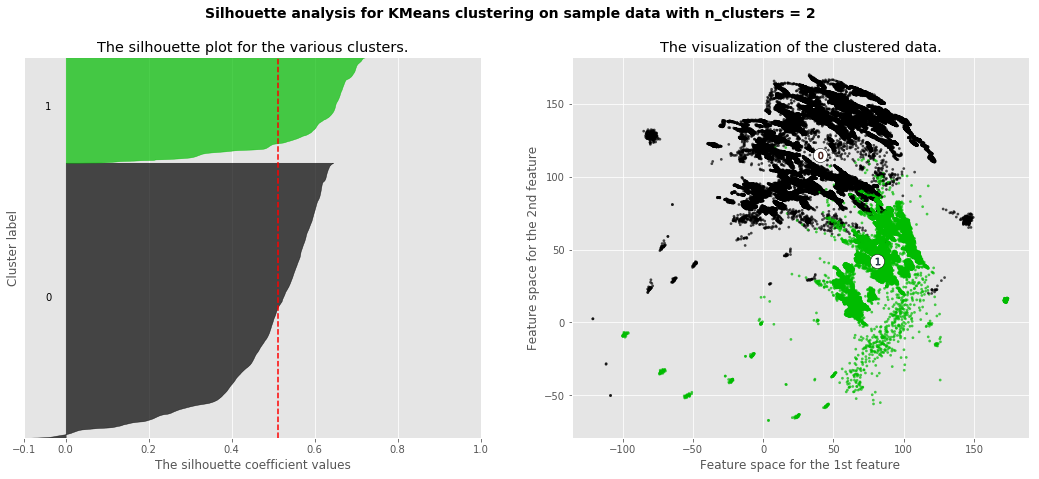

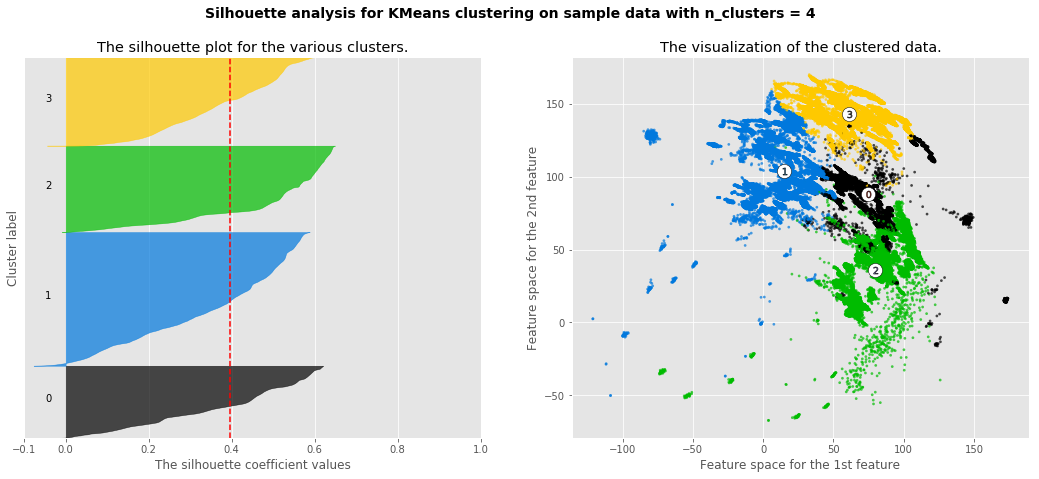

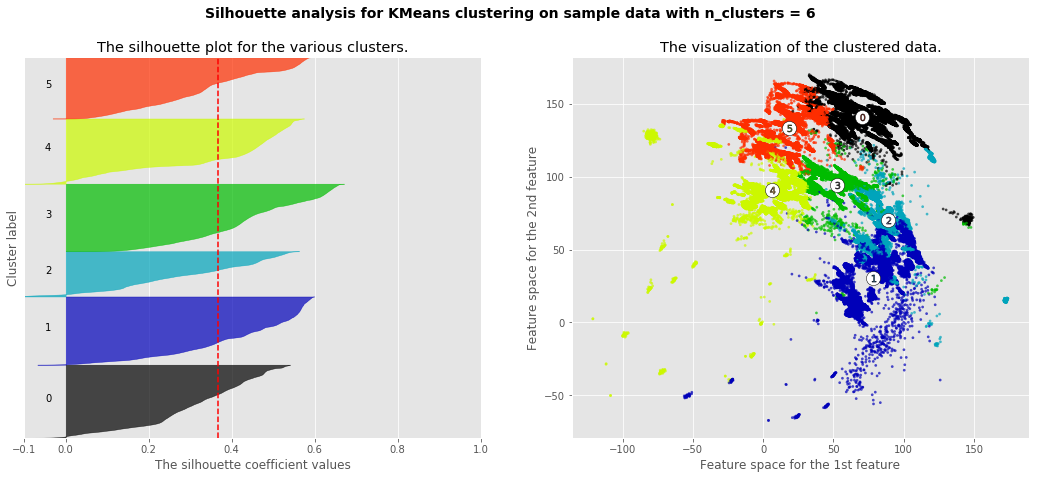

In [142]:
silhouette_plots(range_n_clusters, sample_silhouette_values, cluster_labels, X)

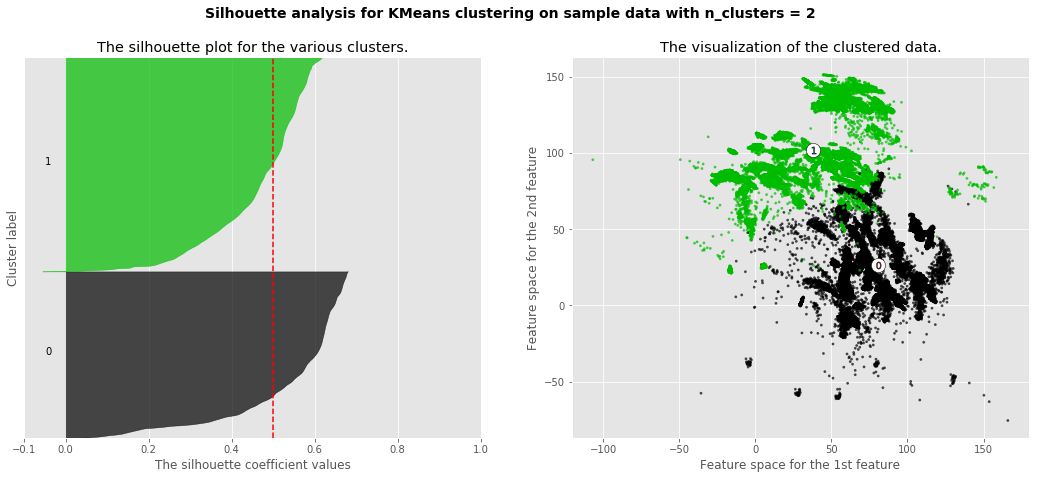

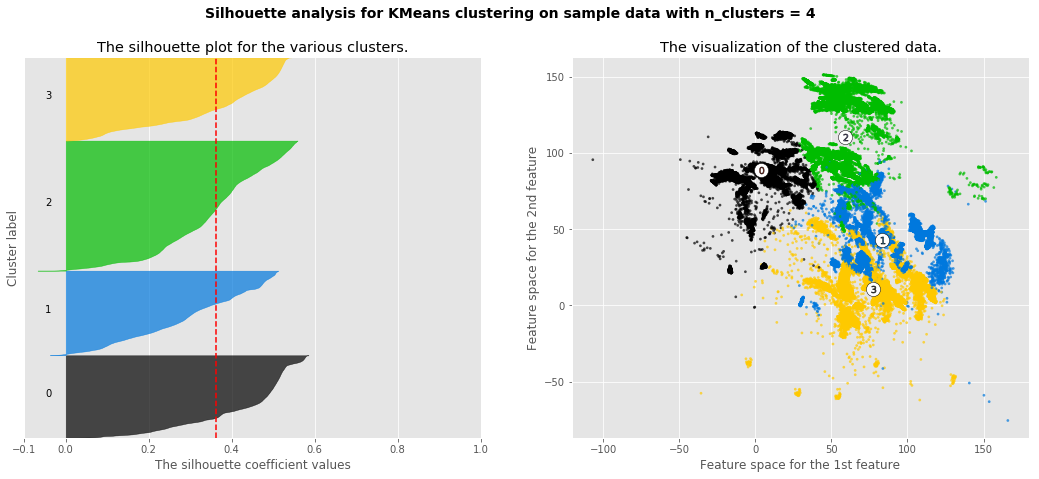

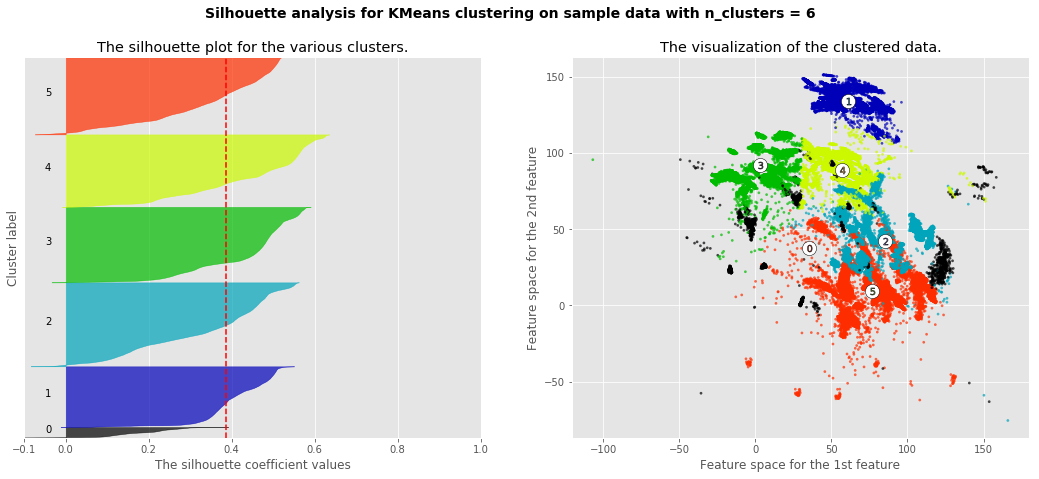

In [145]:
silhouette_plots(range_n_clusters, sample_silhouette_values, cluster_labels, X)

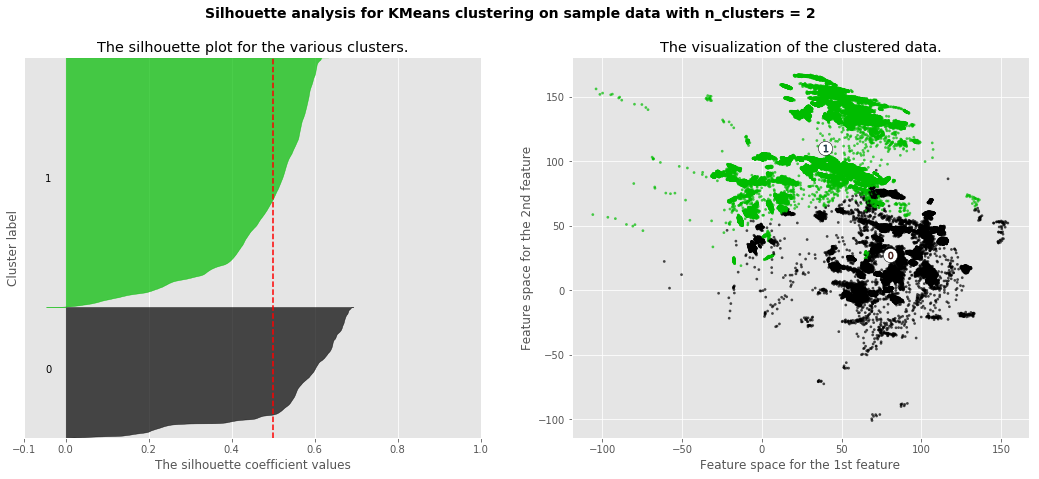

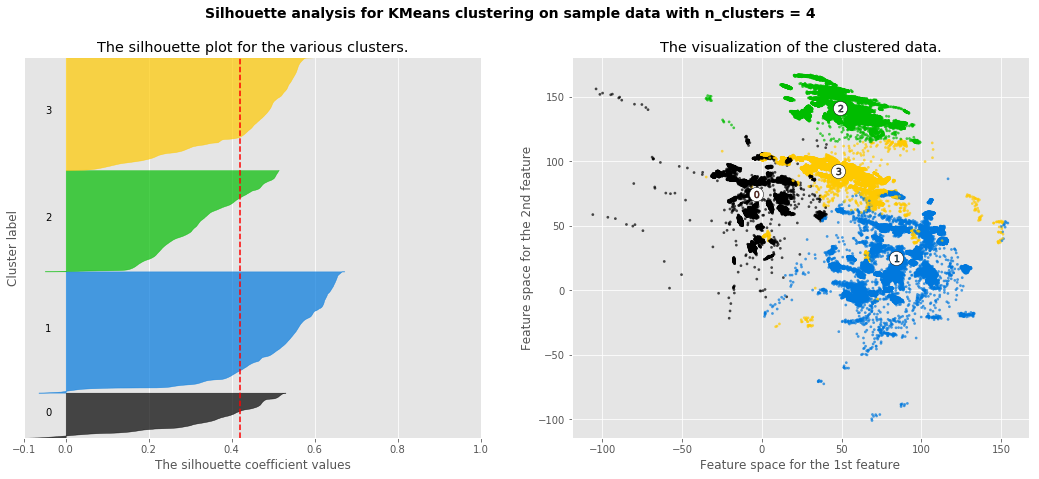

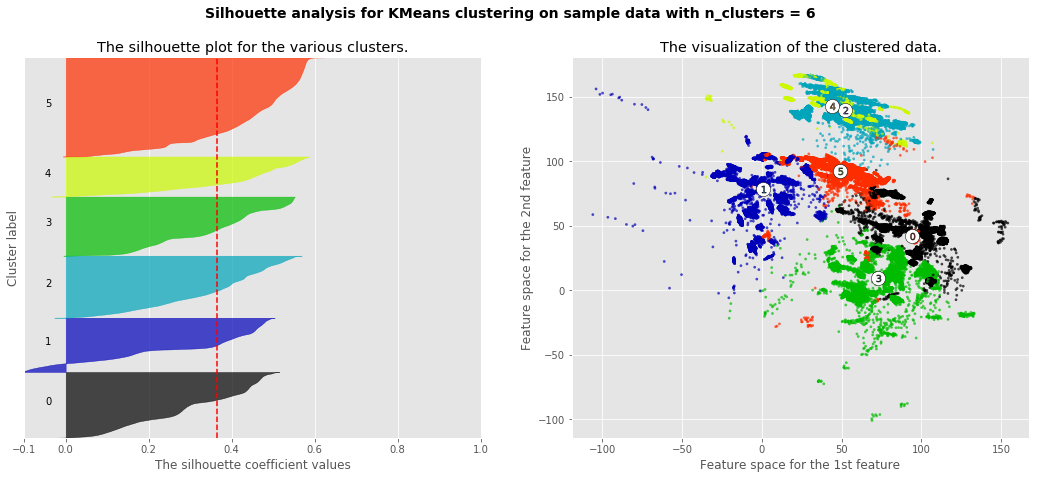

In [148]:
silhouette_plots(range_n_clusters, sample_silhouette_values, cluster_labels, X)

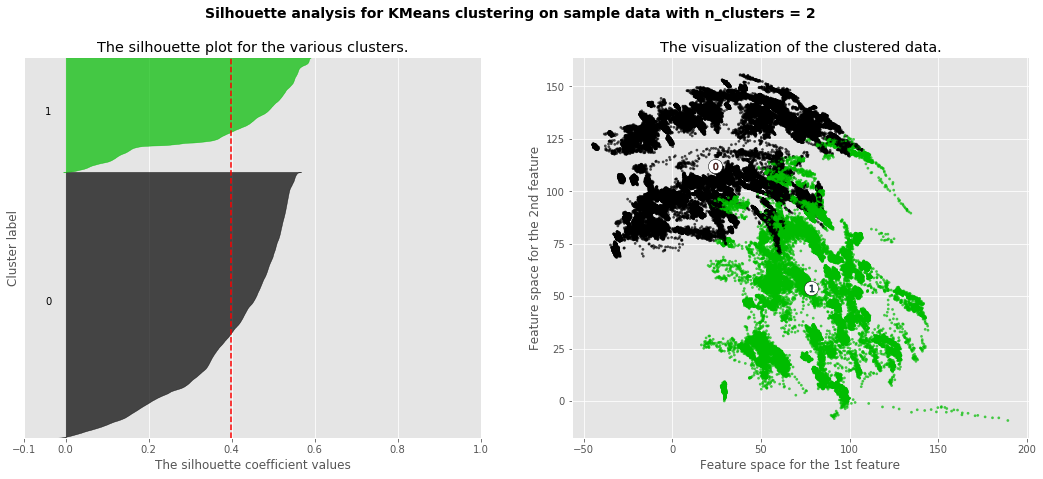

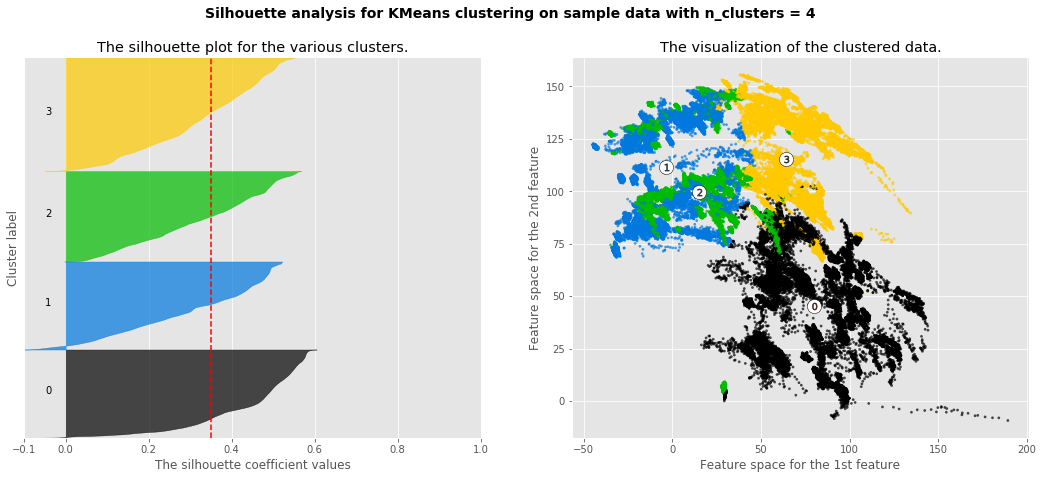

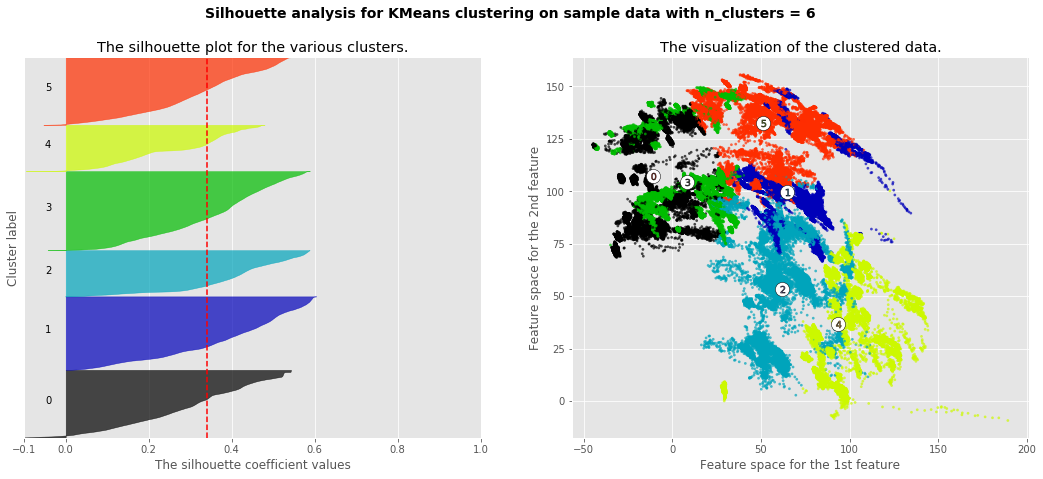

In [151]:
silhouette_plots(range_n_clusters, sample_silhouette_values, cluster_labels, X)

## Modeling and Evaluation 4:
#### Requirements: Summarize the Ramifications

Using all user data for a given gesture makes it difficult to identify the clusters we expect to see based on the way the data is collected and the reference images from the paper.  
 + One way to overcome this is to transform the data (e.g. non-linear principal components) to allow for more separation between clusters. 
 + A second way to overcome the poor clusters resulting from using all gesture data is to use data from a single user.

## Deployment:
#### Requirements: Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
##### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)?
##### How would your deploy your model for interested parties?
##### What other data should be collected? 
#####  How often would the model need to be updated, etc.?



This will lead to a higher silhouette score and potentially to patterns that could be used for prediction.
 
However, filtering the data to specific users naturally reduces the size of the training sample, which can lead to less accurate generalizations and can increase prediction error.

This is because certain users which can be significantly less variable for certain users.

### Exceptional Work:
#### Requirements: You have free reign to provide additional analyses or combine analyses.